<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Single_Layer_DNN_with_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

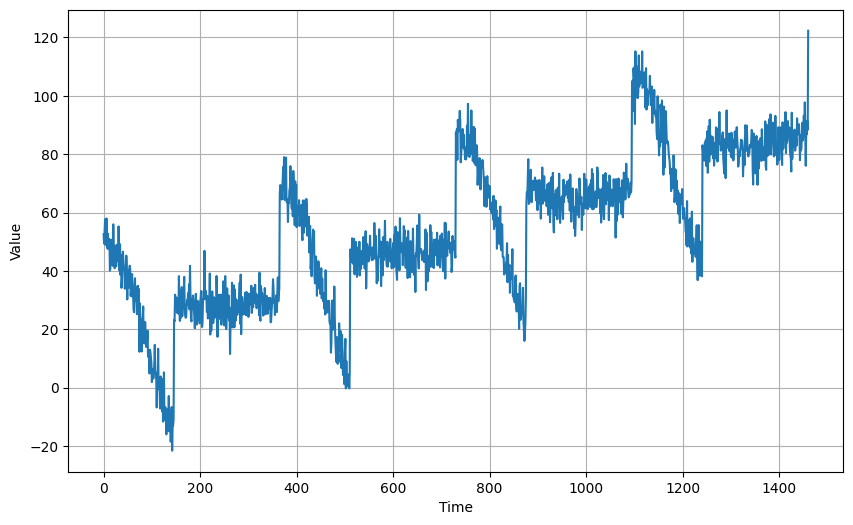

In [34]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [35]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

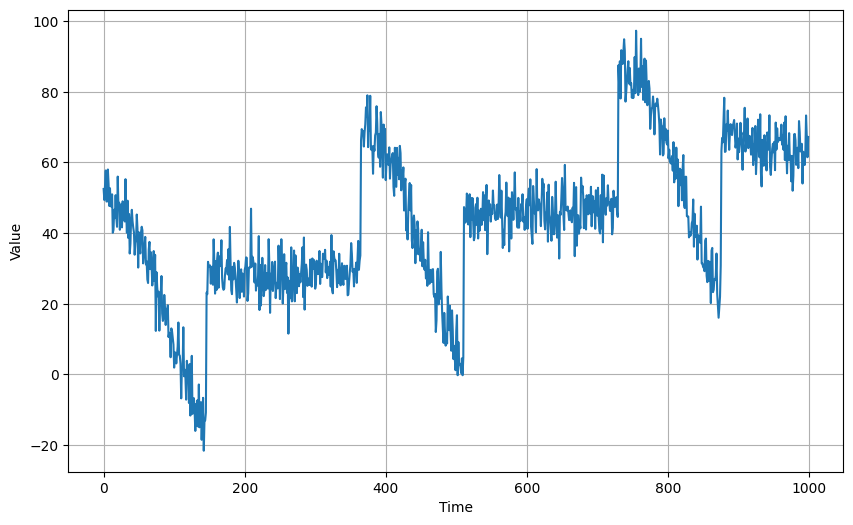

In [5]:
# Plot the train set
plot_series(time_train, x_train)

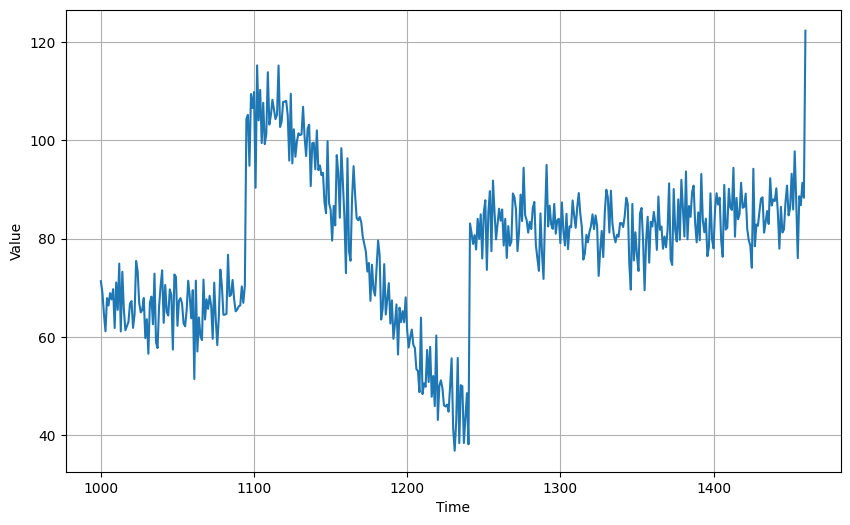

In [36]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [37]:
# Prepare the features and labels

# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [38]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data
  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window : (window[:-1],window[:-1]))

  # Shuffke the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of window
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [12]:
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [39]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32, 20)


In [40]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1,input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer wwights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.3772118 ],
       [ 0.4804595 ],
       [ 0.466011  ],
       [-0.05500939],
       [ 0.49371618],
       [ 0.00932515],
       [ 0.4781962 ],
       [-0.3192322 ],
       [ 0.09909624],
       [-0.38445184],
       [-0.34648067],
       [-0.46426666],
       [ 0.3731948 ],
       [-0.08745372],
       [ 0.37247652],
       [ 0.37473464],
       [ 0.09350842],
       [-0.3147927 ],
       [-0.37576056],
       [ 0.31389308]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6,
        momentum = 0.9)
)

In [42]:
model.fit(dataset,epochs = 100)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 318.2368
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 196.1407
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 163.8301
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 143.4543
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 131.9524
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 123.5980
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 115.9857
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 110.7063
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 105.8301
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 102.1766
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 99.4188
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 95.8837
Epoch 13/100
31

In [43]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.05529333],
       [ 0.04202158],
       [ 0.08864094],
       [-0.03729397],
       [ 0.11216242],
       [ 0.0053402 ],
       [ 0.13830374],
       [-0.02251315],
       [ 0.10981664],
       [ 0.00220398],
       [ 0.05123155],
       [-0.0164317 ],
       [ 0.13648775],
       [-0.00809805],
       [ 0.09721924],
       [ 0.0818028 ],
       [ 0.07272065],
       [-0.01945444],
       [-0.00028519],
       [ 0.1075517 ]], dtype=float32), array([-0.00329823], dtype=float32)]


In [44]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 48ms/step
model prediction: [[48.242]]


In [45]:
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 22ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


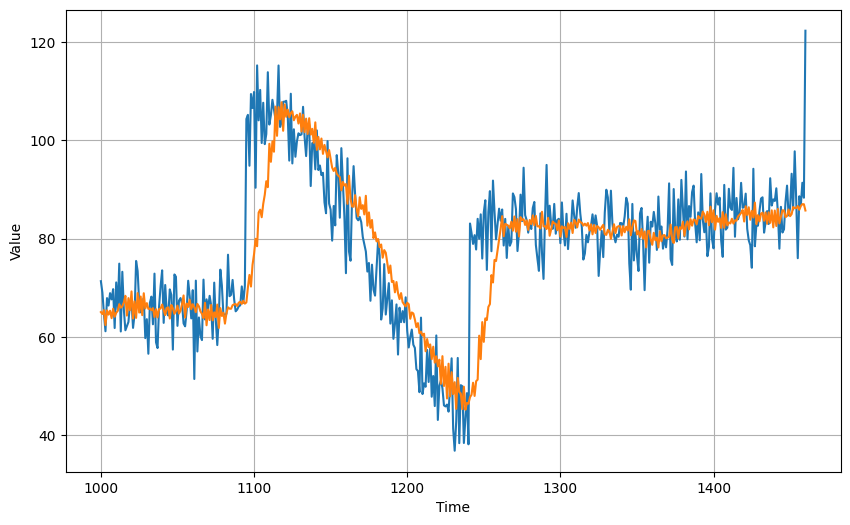

In [46]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [47]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

80.656944
6.0832553
